In [154]:
!pip install Keras
import time
import numpy as np
import pandas as pd
#import dill as pkl
import pickle as pkl
from matplotlib import pyplot as plt
from collections import defaultdict
import nltk
import re
import itertools
import unittest
import RegexTester
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
%matplotlib inline
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers, regularizers, optimizers
from keras.callbacks import History, CSVLogger

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Load Word Embeddings

In [24]:
def loadEmbed(file):
    start = time.time()
    print("Loading Embeddings")
    f = open(file, 'r', encoding='utf-8')
    model = {}
    status_every = 100000
    for i, line in enumerate(f):
        if i%status_every == 0:
            print('Processing line {:,}'.format(i))
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",'{:,}'.format(len(model))," words loaded!")
    end = time.time()
    print("Total Time to load embeddings:", end - start, "seconds")
    return model

In [25]:
#TOO LARGE TO PUSH TO GIT, DOWNLOAD SEPARATLEY FROM https://github.com/stanfordnlp/GloVe
glove_dir = './glove.6B/'
glove_filename = 'glove.6B.300d.txt'
glove_fullpath = glove_dir + glove_filename
glove_dd = loadEmbed(glove_fullpath)

Loading Embeddings
Processing line 0
Processing line 100,000
Processing line 200,000
Processing line 300,000
Processing line 400,000
Done. 400,001  words loaded!
Total Time to load embeddings: 41.43394422531128 seconds


# BINARIZE LABELS

In [ ]:
full_data = pkl.load(open("full_data_w_flattened_plots.pkl", 'rb'))

In [123]:
from sklearn.preprocessing import MultiLabelBinarizer

In [124]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(full_data["list_genres"])
full_data["binarized_labels"] = y_train.tolist()

In [170]:
mlb.classes_

2

# TRAIN/TEST SPLIT

# Read Full Data and Generate Embeddings for BOW

In [171]:
full_data["plot_lengths"] = full_data["flattened_tokens"].apply(lambda row: len(row))

49.0


(array([7.0940e+03, 1.0725e+05, 7.3764e+04, 4.0858e+04, 1.9968e+04,
        6.4460e+03, 3.8200e+02, 4.9000e+01, 3.4000e+01, 8.0000e+00]),
 array([  4. ,  22.4,  40.8,  59.2,  77.6,  96. , 114.4, 132.8, 151.2,
        169.6, 188. ]),
 <a list of 10 Patch objects>)

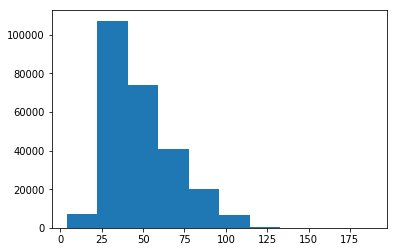

In [183]:
print(np.percentile(full_data["plot_lengths"],60))
plt.hist(full_data["plot_lengths"])

In [126]:
def embed_plot_BOW(plot):
    word_embeddings = np.array([glove_dd.get(word, glove_dd.get("unk")) for word in plot]).astype(np.float32)
    sentence_embedding = [sum(dim) for dim in zip(*word_embeddings)]
    return np.array(sentence_embedding)

In [128]:
print("Embedding plots...")
start = time.time()
full_data["flattened_embeddings"] = full_data["flattened_tokens"].apply(lambda row: embed_plot_BOW(row))
end = time.time()
print("Total Time to embed plots:", end - start, "seconds")

Embedding plots...
Total Time to embed plots: 813.7513613700867 seconds


In [129]:
full_data.to_pickle("./full_data_w_flattened_embeddings.pkl")

In [61]:
full_data_sample = full_data.iloc[0:2] #sample to start with

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(full_data["flattened_embeddings"], 
                                                    full_data["binarized_labels"], test_size=0.20, random_state=42)
#x_train = np.stack(full_data_sample["flattened_embeddings"].values)

In [150]:
X_train_sample = np.stack(X_train[0:5].values)
y_train_sample = np.stack(y_train[0:5].values)
X_test_sample = np.stack(X_test[0:5].values)
y_test_sample = np.stack(y_test[0:5].values)

In [167]:
model = Sequential()
model.add(Dense(30, input_shape=(X_train_sample.shape[1],), activation='tanh'))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.fit(X_train_sample, y_train_sample, epochs = 10, batch_size = 1)
preds = model.predict(X_test_sample)

Epoch 1/10
5/5 [==============================] - 1s 187ms/step - loss: 0.7315
Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.5845
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.4793
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.4339
Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3863
Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3607
Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3411
Epoch 8/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3181
Epoch 9/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2990
Epoch 10/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2820


In [168]:
preds[1]

array([0.2602753 , 0.19197786, 0.12099763, 0.41566122, 0.39981753,
       0.02450203, 0.84904957, 0.05401424, 0.1990685 , 0.15403534,
       0.1546099 , 0.2770333 , 0.29994798, 0.16051006, 0.07285116,
       0.07787725, 0.109128  , 0.42329025, 0.57406867, 0.13439035],
      dtype=float32)

In [169]:
y_test_sample[1]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])